## Setup

In [ ]:
#!git clone https://github.com/pikalab-unibo-students/master-thesis-dizio-ay2324.git

fatal: destination path 'master-thesis-dizio-ay2324' already exists and is not an empty directory.


In [3]:
import utils
import pandas as pd
import numpy as np

# Ethics
import chardet
import fairlib as fl
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio

# Statistics
from matplotlib import pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

# Classification
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import torch
import torch.nn as nn

In [4]:
# Allowing reproducibility
random_seed = 42
np.random.seed(random_seed)

## Dataset Loading

In [5]:
dataset_path = 'direct_matching_20240213.csv'

In [6]:
with open(dataset_path, 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']

In [7]:
df = fl.DataFrame(pd.read_csv(dataset_path, delimiter=';', encoding=encoding))

## Data Preparation

We have to carefully prepare the dataset for classification avoiding <b>sample bias</b>, i.e., avoiding that the negative examples are biased. Note: we cannot do anything for an eventual bias in the hiring process (when we pick the top-1 candidate), and it would be incorrect too since our task is focusing on that kind of bias.

In [8]:
df.head(11)

,cand_id,job_id,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,job_contract_type,job_professional_category,job_sector,job_work_province
0,"5,664,912",OFF_1011_1427,32.327042,99.573387,1,Male,45-54,UD,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
1,"4,999,120",OFF_1011_1427,15.595593,99.210564,2,Male,35-44,UD,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
2,"5,413,671",OFF_1011_1427,31.348877,99.118614,3,Female,45-54,UD,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
3,"5,965,090",OFF_1011_1427,66.315598,97.409767,4,Male,15-24,TS,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
4,"5,771,219",OFF_1011_1427,15.595593,97.323875,5,Female,35-44,UD,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
5,"2,216,205",OFF_1011_1427,24.946939,96.922318,6,Male,55-74,UD,FRIULI VENEZIA GIULIA,Diploma / Accademia : Geometra,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
6,"4,594,051",OFF_1011_1427,27.959969,96.245216,7,Male,55-74,UD,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
7,"5,148,878",OFF_1011_1427,25.512180,96.235245,8,Male,25-34,UD,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
8,"5,933,345",OFF_1011_1427,28.856832,96.009712,9,Female,45-54,GO,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
9,"7,204,128",OFF_1011_1427,31.348877,95.802277,10,Female,35-44,UD,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD


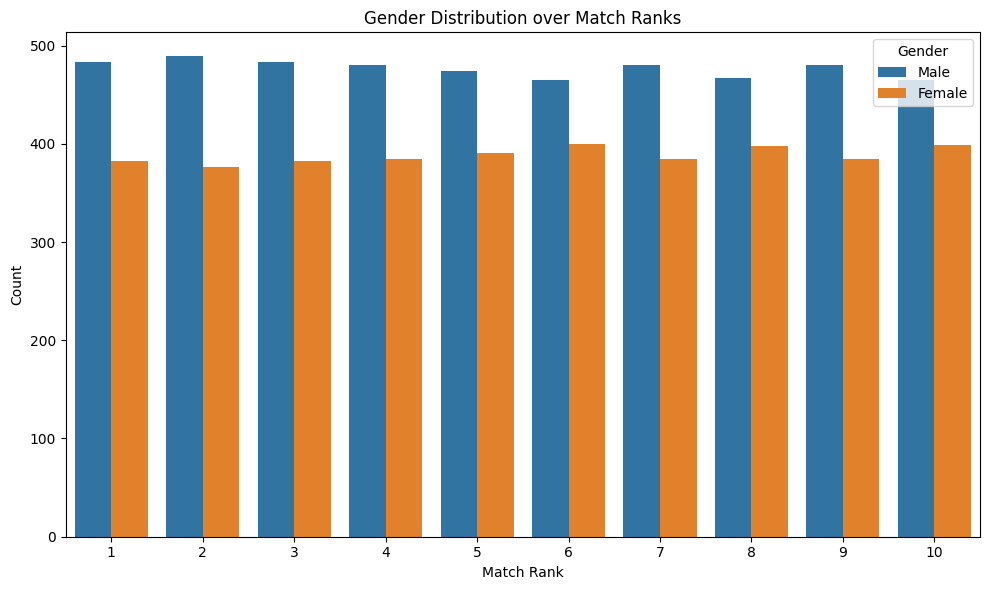

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='match_rank', hue='cand_gender', order=range(1, 11))
plt.title('Gender Distribution over Match Ranks')
plt.xlabel('Match Rank')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

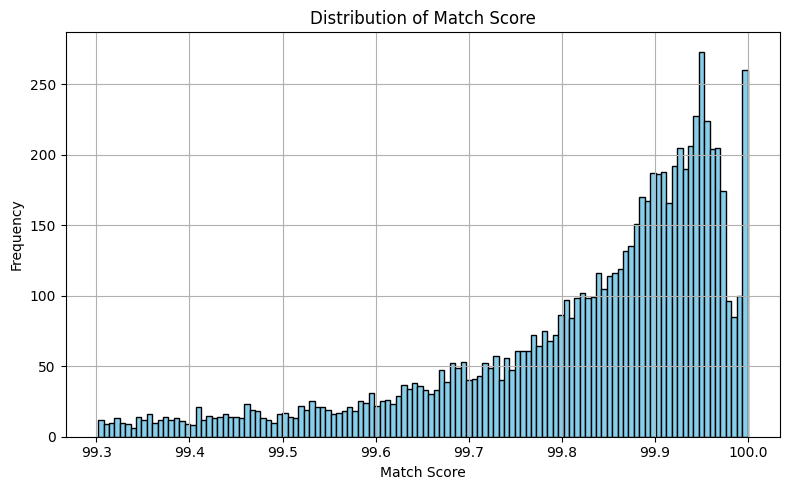

In [10]:
plt.figure(figsize=(8, 5))
plt.hist(df[df['match_score'] > 99.3]['match_score'], bins=120, color='skyblue', edgecolor='black')
plt.title('Distribution of Match Score')
plt.xlabel('Match Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

We can assume that a candidate is hired if its match score is greater than a significant threshold, for instance, th=99.8

In [11]:
hired_threshold = 99.9

In [12]:
df1 = df.copy()

In [13]:
df1['hired'] = (df1['match_score'] >= hired_threshold).astype(int)

In [14]:
df1.shape

(8647, 15)

In [15]:
len(df1[df1['hired'] == 1])

3199

In [16]:
df1.targets = {'hired'}

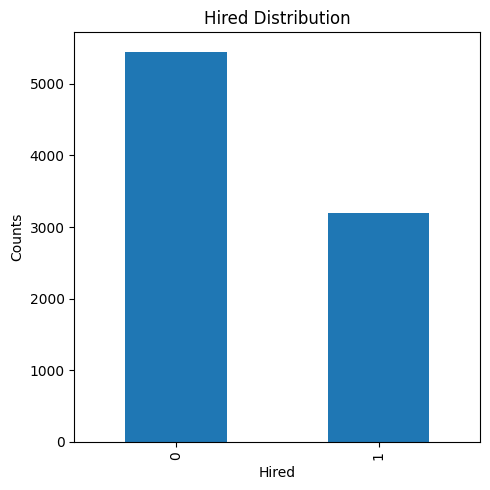

In [17]:
plt.figure(figsize=(5, 5))
df1['hired'].value_counts().plot(kind='bar')
plt.xlabel('Hired')
plt.ylabel('Counts')
plt.title('Hired Distribution')
plt.tight_layout()
plt.show()

Both the match rank and the match score are useless now that we extract the label, so we can drop them.

In [18]:
df1.drop(['match_score','match_rank'], axis=1, inplace=True)

In [19]:
df1.head()

,cand_id,job_id,distance_km,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,job_contract_type,job_professional_category,job_sector,job_work_province,hired
0,"5,664,912",OFF_1011_1427,32.327042,Male,45-54,UD,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD,0
1,"4,999,120",OFF_1011_1427,15.595593,Male,35-44,UD,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD,0
2,"5,413,671",OFF_1011_1427,31.348877,Female,45-54,UD,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD,0
3,"5,965,090",OFF_1011_1427,66.315598,Male,15-24,TS,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD,0
4,"5,771,219",OFF_1011_1427,15.595593,Female,35-44,UD,FRIULI VENEZIA GIULIA,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD,0


## Data Preprocessing

Before continuing with the data analysis we want to ensure that missing values are handled correctly and the data are ready to be feed in a classifier. Let's inspect some of their statistics.

In [20]:
print(f'Examples in the dataset: {df1.shape[0]}')

Examples in the dataset: 8647


In [21]:
df1.describe(include='all')

,cand_id,job_id,distance_km,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,job_contract_type,job_professional_category,job_sector,job_work_province,hired
count,8647,8647,8647.000000,8647,8646,8644,8642,2341,8647,8647,8647,8647,8647.000000
unique,6798,865,NaN,2,5,79,18,433,3,247,26,53,NaN
top,"6,550,205",ORD_9846_0445,NaN,Male,25-34,MI,LOMBARDIA,Licenza media,Lavoro subordinato,Operaio Generico Metalmeccanico,Operai Generici,MI,NaN
freq,18,10,NaN,4766,2936,1341,3989,433,5658,770,2829,1689,NaN
mean,NaN,NaN,29.769432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.369955
std,NaN,NaN,23.493063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.482820
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,12.253924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,23.447361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,41.754654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


Most of the variables doen't miss any value, except for the <b>candidate domicile province</b> which misses just 3 values, the <b>candidate domicile region</b> which misses only 5 values, the <b>candidate age</b> which misses only 1 value and the <b>candidate education</b>, which instead misses way more values. We can account for the 3 missing  values by simply drop the related rows, but we must find a default value for the education since the rows containing missing values are too much.

In [22]:
df1 = df1[~df1['cand_domicile_province'].isnull()]
df1 = df1[~df1['cand_domicile_region'].isnull()]
df1 = df1[~df1['cand_age_bucket'].isnull()]

In general, we can keep all the numerical values, but we have to account for the categorical ones in order to feed a classifier. In the next paragraphs we will focus on the features that require our attention.

### IDs

Candidate id and job id are meaningless for the task of bias detection, hence we can easily drop them.

In [23]:
df1.drop(['cand_id','job_id'], axis=1, inplace=True)

### Distance Km

In [24]:
df1['distance_km'].describe()

count    8639.000000
mean       29.754485
std        23.484031
min         0.000000
25%        12.252331
50%        23.437698
75%        41.751572
max        99.966797
Name: distance_km, dtype: float64

We can approximate the distance by rounding it.

In [26]:
df1['distance_km'] = df1['distance_km'].apply(lambda d : round(d)).astype(int)

In [27]:
df1['distance_km'].describe()

count    8639.000000
mean       29.746846
std        23.475636
min         0.000000
25%        12.000000
50%        23.000000
75%        42.000000
max       100.000000
Name: distance_km, dtype: float64

First of all, let's inspect the distribution.

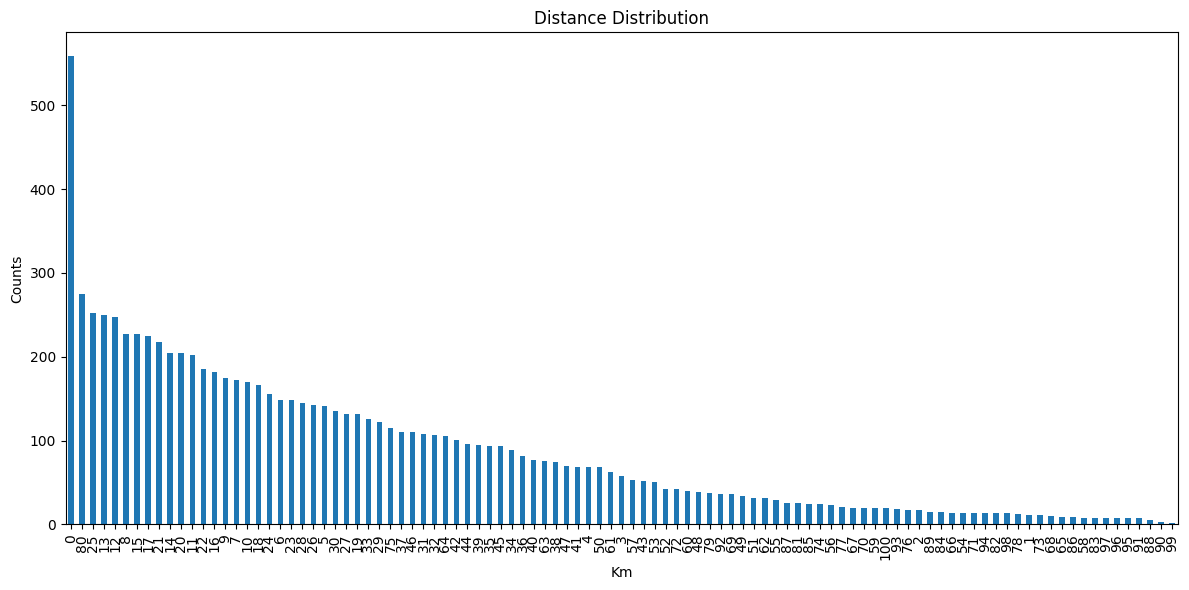

In [28]:
# Visualize the distribution
plt.figure(figsize=(12, 6))
df1['distance_km'].value_counts().plot(kind='bar')
plt.xlabel('Km')
plt.ylabel('Counts')
plt.title('Distance Distribution')
plt.tight_layout()
plt.show()

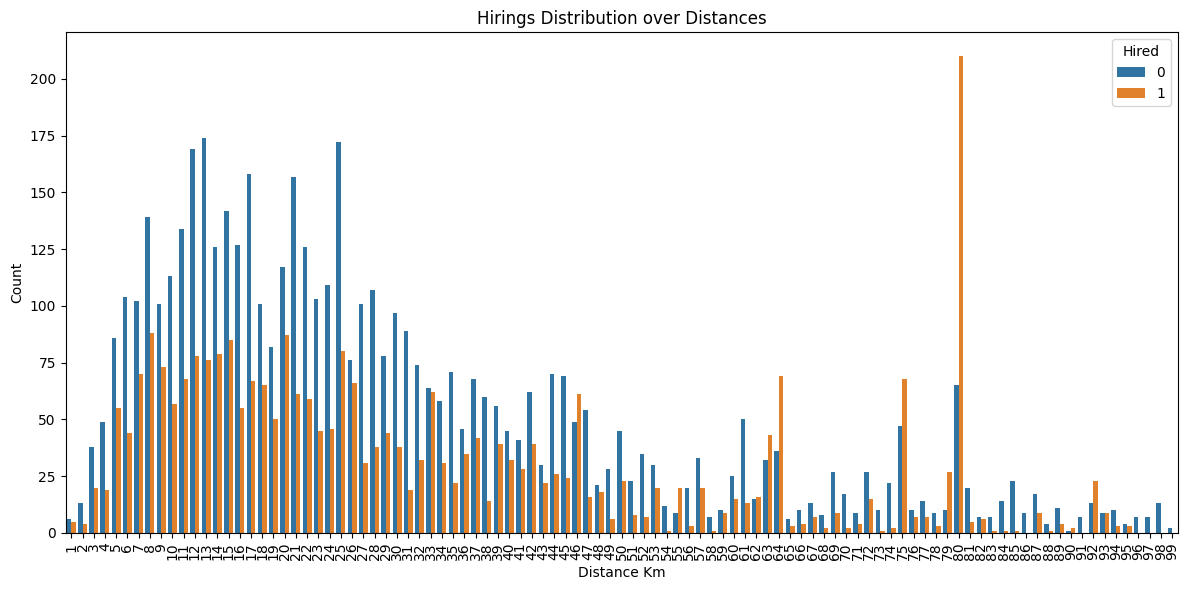

In [29]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df1, x='distance_km', hue='hired', order=range(1, max(df1['distance_km'])))
plt.title('Hirings Distribution over Distances')
plt.xlabel('Distance Km')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

There is no particular bias related to this feature. The fact that the hired counts per distance are not uniform is probably due to other factors.

### Candidate Gender

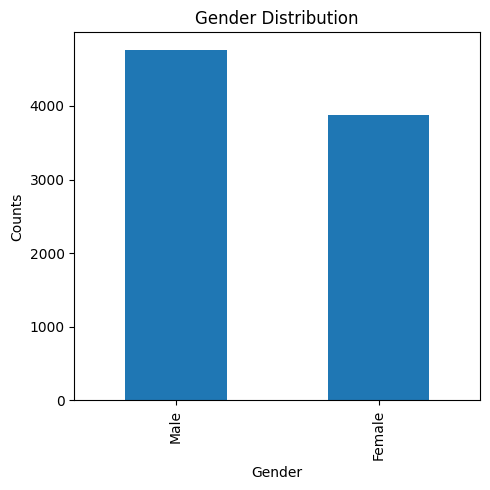

In [30]:
# Visualize the distribution
plt.figure(figsize=(5, 5))
df1['cand_gender'].value_counts().plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.title('Gender Distribution')
plt.tight_layout()
plt.show()

The dataset is imbalanced, but this tell us nothing about any possible bias or unfairness. In order to spot any kind of unfairness we should compare this distribution with the hirings.

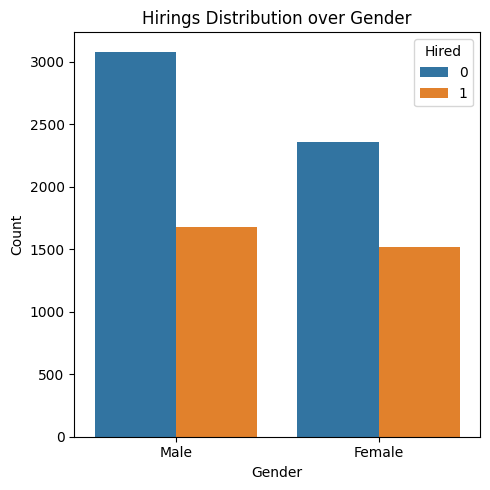

In [31]:
plt.figure(figsize=(5, 5))
sns.countplot(data=df1, x='cand_gender', hue='hired')
plt.title('Hirings Distribution over Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.tight_layout()
plt.show()

Here we can spot a huge gender bias, despite the distribution of genders is not uniform. We should compare this property with the other features in order to spot the various biases (in job sectors for instance).

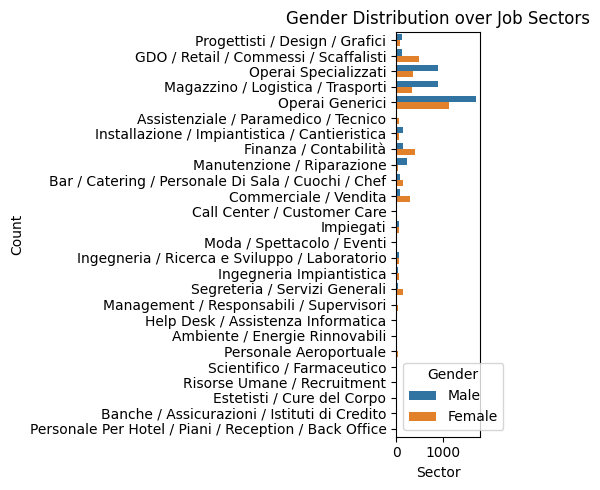

In [32]:
plt.figure(figsize=(5, 5))
sns.countplot(data=df1, y='job_sector', hue='cand_gender')
plt.title('Gender Distribution over Job Sectors')
plt.xlabel('Sector')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

It is evident that there is some bias related to the gender in most of the sectors, so we mark it as sensitive.

In [33]:
sensitive_features = ['cand_gender']

In [34]:
# Preprocessing
df1['cand_gender'] = df1['cand_gender'].apply(lambda s: int(str.lower(s) == 'male'))

### Candidate Province

In [35]:
df1['cand_domicile_province'].describe()

count     8639
unique      78
top         MI
freq      1340
Name: cand_domicile_province, dtype: object

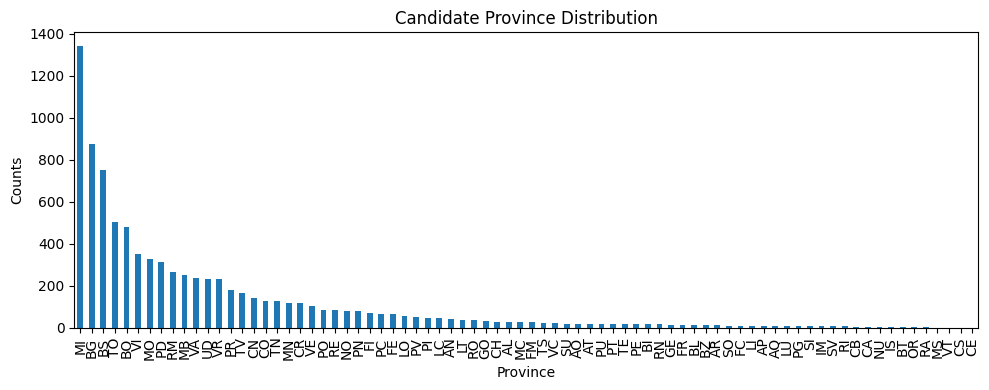

In [36]:
# Visualize the distribution
plt.figure(figsize=(10, 4))
df1['cand_domicile_province'].value_counts().plot(kind='bar')
plt.xlabel('Province')
plt.ylabel('Counts')
plt.title('Candidate Province Distribution')
plt.tight_layout()
plt.show()

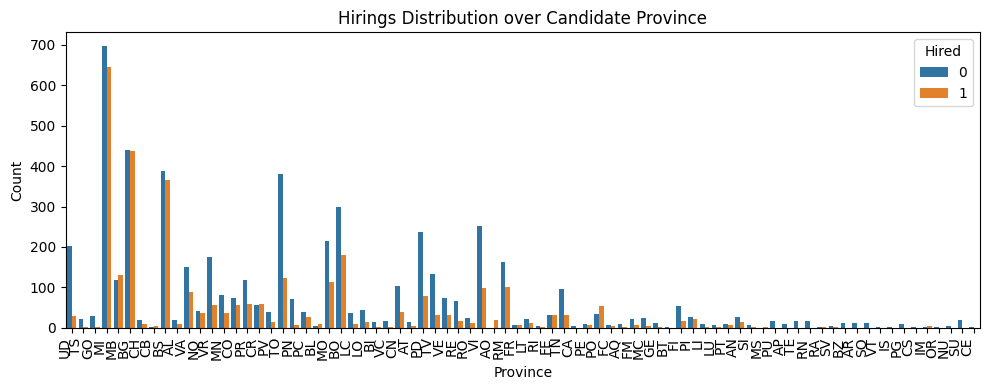

In [37]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df1, x='cand_domicile_province', hue='hired')
plt.title('Hirings Distribution over Candidate Province')
plt.xlabel('Province')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

This comparison doesn't make so much sense alone.

In order to preprocess this feature, we have to ensure that even the job work province will be coherent with the candidate province, therefore we will use the same encoder for both of them.

In [38]:
province_encoder = OrdinalEncoder()
df1['cand_domicile_province'] = province_encoder.fit_transform(df1[['cand_domicile_province']])

### Domicile Region

In [39]:
df1['cand_domicile_region'].describe()

count          8639
unique           18
top       LOMBARDIA
freq           3988
Name: cand_domicile_region, dtype: object

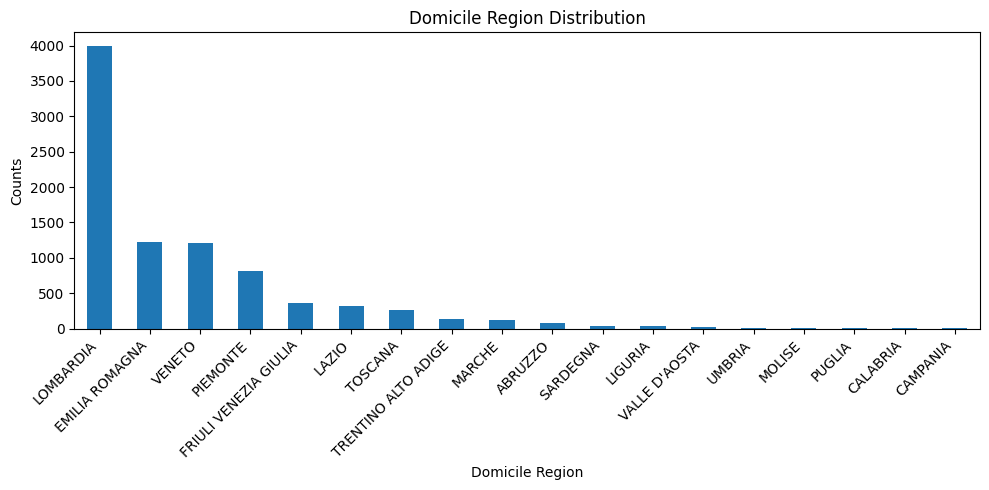

In [40]:
# Visualize the distribution
plt.figure(figsize=(10, 5))
df1['cand_domicile_region'].value_counts().plot(kind='bar')
plt.xlabel('Domicile Region')
plt.ylabel('Counts')
plt.title('Domicile Region Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

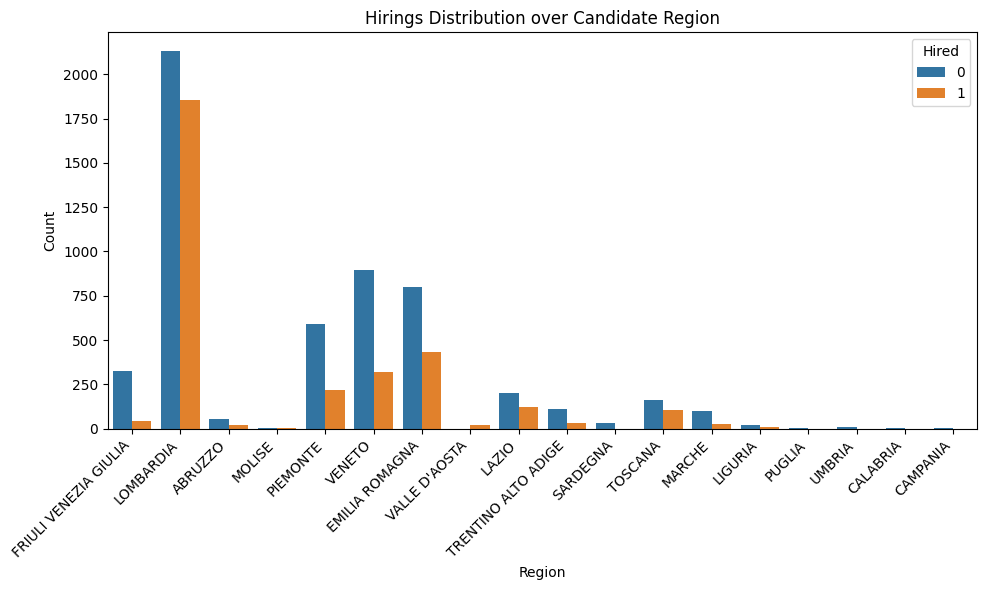

In [41]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df1, x='cand_domicile_region', hue='hired')
plt.title('Hirings Distribution over Candidate Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This last plot shows that there are no biases in the region, thus we can assume that there are no bias in the province feature too. Note that the regions of the south are not well represented, so any bias related to the north-south discrimination won't be catched.

A one-hot wencoding would be too heavy for too much regions, thus we can group them into south, central and north regions and then one-hot encode them.

In [42]:
region_groups = {
    # North
    'piemonte': 'north',
    'valle d\'aosta': 'north',
    'lombardia': 'north',
    'veneto': 'north',
    'friuli venezia giulia': 'north',
    'liguria': 'north',
    'emilia romagna': 'north',
    'trentino alto adige': 'north',

    # Central
    'toscana': 'central',
    'umbria': 'central',
    'marche': 'central',
    'lazio': 'central',

    # South
    'abruzzo': 'south',
    'molise': 'south',
    'campania': 'south',
    'puglia': 'south',
    'basilicata': 'south',
    'calabria': 'south',

    # Islands
    'sicilia': 'south',
    'sardegna': 'south'
}

In [43]:
grouped_regions = df1['cand_domicile_region'].apply(lambda r : region_groups[str.lower(r)])

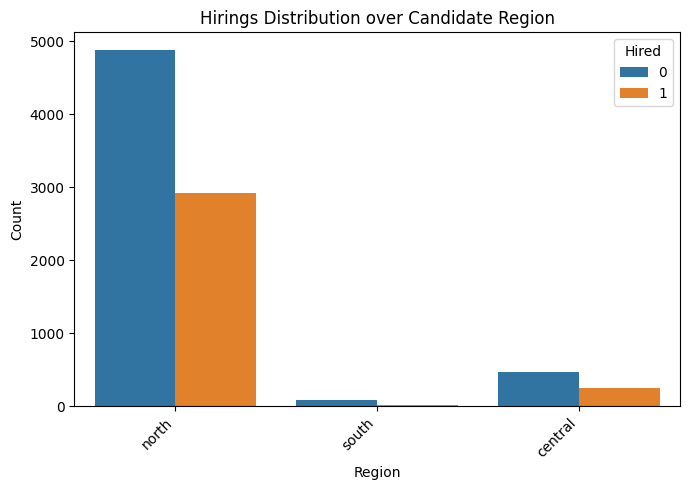

In [44]:
plt.figure(figsize=(7, 5))
sns.countplot(data=df1, x=grouped_regions, hue='hired')
plt.title('Hirings Distribution over Candidate Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [45]:
region_encoder = OrdinalEncoder()
df1['cand_domicile_region'] = region_encoder.fit_transform(df1[['cand_domicile_region']])

In [46]:
#df1 = pd.get_dummies(df1, columns=['cand_domicile_region'], prefix='region', drop_first=False, dtype=int)

### Age Buckets

In [47]:
df1['cand_age_bucket'].unique()

array(['45-54', '35-44', '15-24', '55-74', '25-34'], dtype=object)

In [48]:
print(f"Null age buckets: {df1['cand_age_bucket'].isnull().sum()}")

Null age buckets: 0


Since it is only one we can safely drop it.

In [49]:
df1['cand_age_bucket'].value_counts()

cand_age_bucket
25-34    2935
35-44    2129
45-54    1777
55-74     956
15-24     842
Name: count, dtype: int64

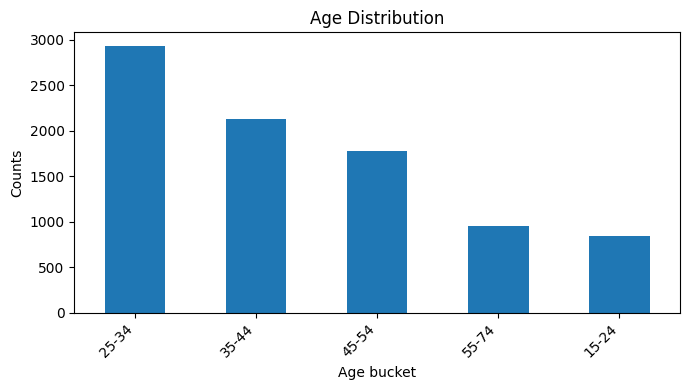

In [50]:
plt.figure(figsize=(7, 4))
df1['cand_age_bucket'].value_counts().plot(kind='bar')
plt.xlabel('Age bucket')
plt.ylabel('Counts')
plt.title('Age Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

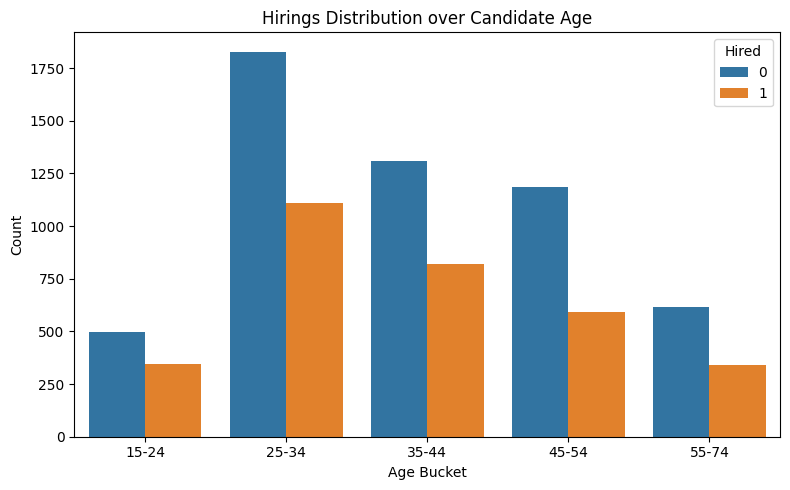

In [51]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df1, x='cand_age_bucket', hue='hired', order=['15-24', '25-34', '35-44', '45-54', '55-74'])
plt.title('Hirings Distribution over Candidate Age')
plt.xlabel('Age Bucket')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.tight_layout()
plt.show()

As we can see, the bias is more heavy in the age which ranges from 25 to 34, probably because it is the mean age range where we decide to make a child, so the company wants to avoid maternity. We mark also this feature as sensitive.

In [52]:
sensitive_features.append('cand_age_bucket')

We can discretize them since they are numerical but preserves the order, thus we will use progressive enumeration.

In [53]:
age_bucket_order = {
    '15-24': 0,
    '25-34': 1,
    '35-44': 2,
    '45-54': 3,
    '55-74': 4,
}

df1['cand_age_bucket'] = df1['cand_age_bucket'].map(age_bucket_order).astype(int)

In [54]:
df1['cand_age_bucket'].value_counts()

cand_age_bucket
1    2935
2    2129
3    1777
4     956
0     842
Name: count, dtype: int64

### Candidate Education

In [55]:
def map_education_level(x):
    if pd.isna(x):
        return 'Unknown'
    x = str(x).lower()

    # Clean common formatting inconsistencies
    x = x.replace('laurea', 'degree')
    x = x.replace('diploma', 'degree')
    
    if 'dottorato' in x or 'phd' in x or 'research doctorate' in x:
        return 'PhD'
    elif 'master' in x or 'lm-' in x:
        return 'Graduate'
    elif 'bachelor' in x or 'l-' in x:
        return 'Undergraduate'
    elif 'higher technical institute' in x or 'its' in x:
        return 'Higher Technical Institute'
    elif 'qualification' in x or 'certificate' in x or 'operator' in x:
        return 'Vocational Certificate'
    elif 'high school' in x or 'liceo' in x or 'technician' in x or 'technical' in x:
        return 'High School'
    elif 'middle school' in x or 'scuola media' in x:
        return 'Middle School'
    elif 'elementary' in x:
        return 'Elementary School'
    else:
        return 'Other'


In [56]:
df1['cand_education'] = df1['cand_education'].apply(map_education_level)

In [57]:
df1['cand_education'].value_counts()

cand_education
Unknown                       6298
Other                         1546
Vocational Certificate         284
High School                    172
Higher Technical Institute     158
Graduate                       120
Undergraduate                   56
PhD                              5
Name: count, dtype: int64

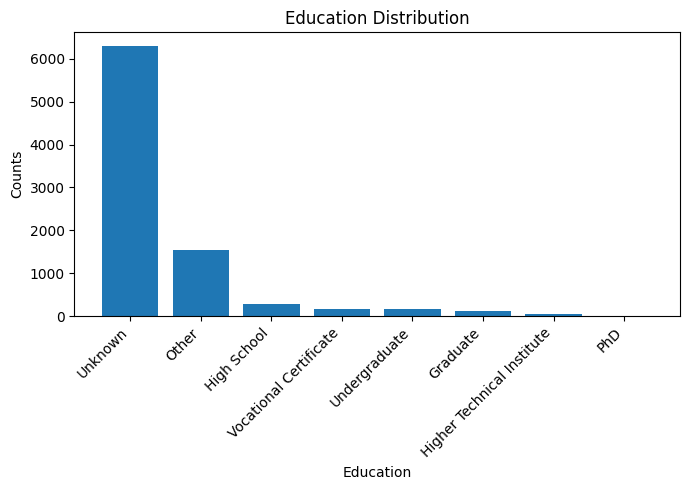

In [58]:
# Visualize the distribution
plt.figure(figsize=(7, 5))
plt.bar(df1['cand_education'].unique(), df1['cand_education'].value_counts())
plt.xlabel('Education')
plt.ylabel('Counts')
plt.title('Education Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

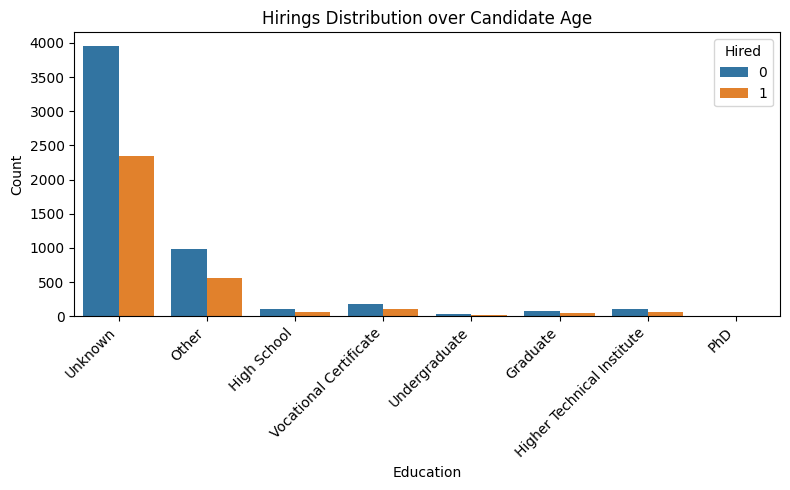

In [59]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df1, x='cand_education', hue='hired')
plt.title('Hirings Distribution over Candidate Age')
plt.xlabel('Education')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

These results are probably not about any bias. However, we cannot say much looking only at this feature.

In [60]:
education_encoder = OrdinalEncoder()
df1['cand_education'] = education_encoder.fit_transform(df1[['cand_education']])

In [61]:
#df1 = pd.get_dummies(df1, columns=['cand_education'], prefix='education', drop_first=False, dtype=int)

### Job Contract Type

In [62]:
df1['job_contract_type'].describe()

count                   8639
unique                     3
top       Lavoro subordinato
freq                    5653
Name: job_contract_type, dtype: object

In [63]:
df1['job_contract_type'].value_counts()

job_contract_type
Lavoro subordinato     5653
Ricerca e selezione    2966
Other                    20
Name: count, dtype: int64

In [64]:
contract_encoder = OrdinalEncoder()
df1['job_contract_type'] = contract_encoder.fit_transform(df1[['job_contract_type']])

In [65]:
#df1 = pd.get_dummies(df1, columns=['job_contract_type'], prefix='contract', drop_first=False, dtype=int)

### Job Category

In [66]:
df1['job_professional_category'].describe()

count                                8639
unique                                247
top       Operaio Generico Metalmeccanico
freq                                  770
Name: job_professional_category, dtype: object

In [67]:
df1['job_professional_category'].unique()

array(['Geometra e tecnico di costruzioni civili e industriali',
       'Macellaio (m/f)', 'saldatore/saldatrice',
       'Capo Reparto grande distribuzione organizzata',
       'Autista di autocarro a portale (m/f)',
       'magazziniere/magazziniera', 'Operaio Generico Edile',
       'Operatore CNC (m/f)', 'Infermiere',
       'addetto alla lavorazione dei metalli',
       'O.S.S. (operatore socio sanitario)',
       'addetto controllo qualità prodotti',
       'Meccanico/Attrezzista dispositivi per la saldatura (m/f)',
       'Tecnico di cantiere', 'assistente contabile',
       "Addetto all'assemblaggio di elettrodomestici (m/f)",
       'Attrezzista di macchine per lo stampaggio (m/f)', 'Autista',
       'Operaio Generico Manifatturiero', 'Addetto al montaggio (m/f)',
       'manutentore', 'Addetto al confezionamento (m/f)',
       'Operaio Generico Servizi/Terziario',
       'Operaio Generico Gomma/Plastica', 'Addetto Fast Food',
       'Responsabile punto vendita/filiale', 'idra

In [68]:
#job_categories_group = df1['job_professional_category'].apply(lambda category : utils.map_job_category(category))

In [69]:
'''
plt.figure(figsize=(5, 5))
sns.countplot(data=df1, y=job_categories_group, hue='cand_gender')
plt.title('Gender Distribution over Job Categories')
plt.xlabel('Job Category')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()
'''

"\nplt.figure(figsize=(5, 5))\nsns.countplot(data=df1, y=job_categories_group, hue='cand_gender')\nplt.title('Gender Distribution over Job Categories')\nplt.xlabel('Job Category')\nplt.ylabel('Count')\nplt.legend(title='Gender')\nplt.tight_layout()\nplt.show()\n"

Here it is more clear how much this dataset is biased against the gender.

In [70]:
category_encoder = OrdinalEncoder()
df1['job_professional_category'] = category_encoder.fit_transform(df1[['job_professional_category']])

In [71]:
#df1 = pd.get_dummies(df1, columns=['job_professional_category'], prefix='category', drop_first=False, dtype=int)

### Job Sector

In [72]:
df1['job_sector'].describe()

count                8639
unique                 26
top       Operai Generici
freq                 2827
Name: job_sector, dtype: object

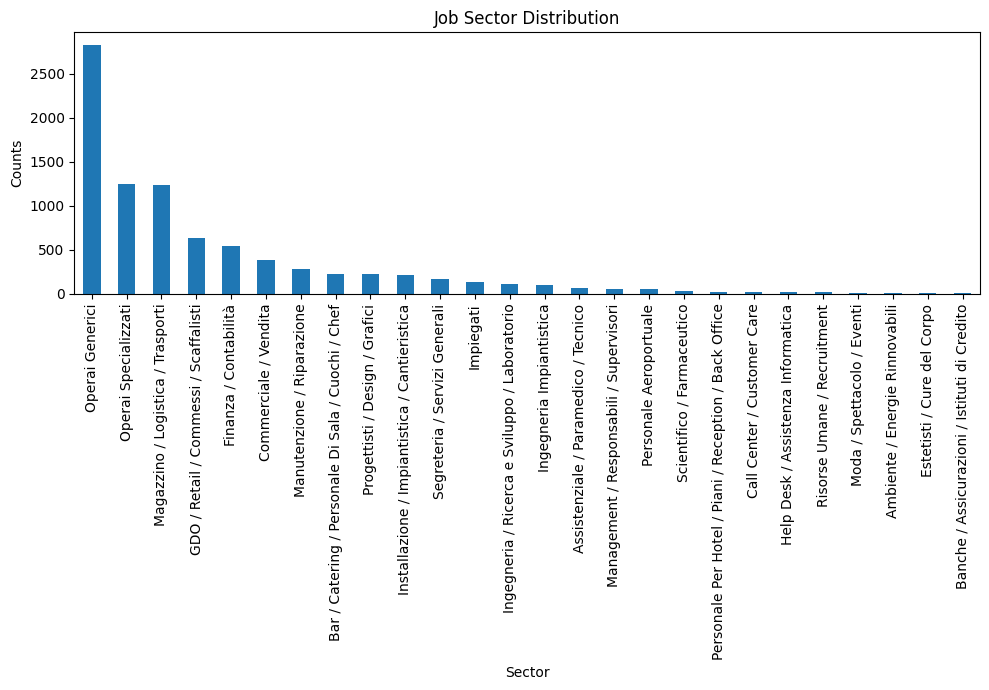

In [73]:
# Visualize the distribution
plt.figure(figsize=(10, 7))
df1['job_sector'].value_counts().plot(kind='bar')
plt.xlabel('Sector')
plt.ylabel('Counts')
plt.title('Job Sector Distribution')
plt.tight_layout()
plt.show()

In [74]:
counts = df1['job_sector'].value_counts()
min_count = 200

rare = counts[counts < min_count].index

df1 = df1[~df1['job_sector'].isin(rare)]

In [75]:
df1['job_sector'].value_counts()

job_sector
Operai Generici                                       2827
Operai Specializzati                                  1246
Magazzino / Logistica / Trasporti                     1239
GDO / Retail / Commessi / Scaffalisti                  630
Finanza / Contabilità                                  539
Commerciale / Vendita                                  380
Manutenzione / Riparazione                             279
Bar / Catering / Personale Di Sala / Cuochi / Chef     230
Progettisti / Design / Grafici                         220
Installazione / Impiantistica / Cantieristica          210
Name: count, dtype: int64

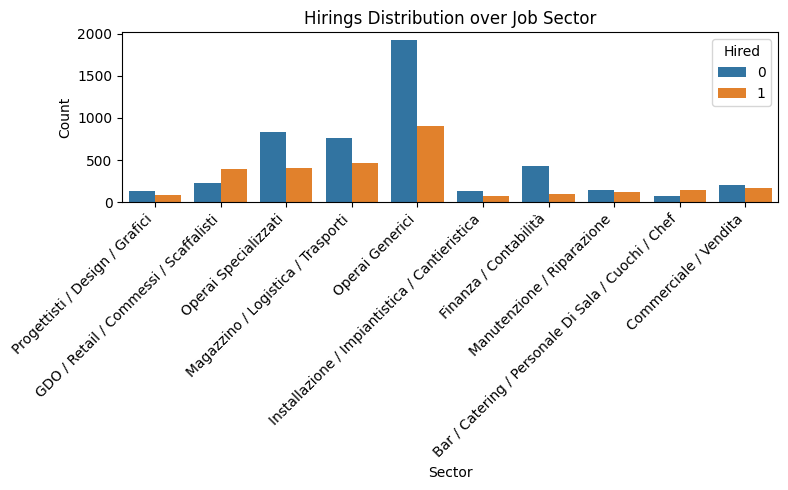

In [76]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df1, x='job_sector', hue='hired')
plt.title('Hirings Distribution over Job Sector')
plt.xlabel('Sector')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [77]:
sector_encoder = OrdinalEncoder()
df1['job_sector'] = sector_encoder.fit_transform(df1[['job_sector']])

In [78]:
#df1 = pd.get_dummies(df1, columns=['job_sector'], prefix='sector', drop_first=False, dtype=int)

### Job Work Province

In [79]:
df1['job_work_province'].describe()

count     7800
unique      53
top        MI 
freq      1347
Name: job_work_province, dtype: object

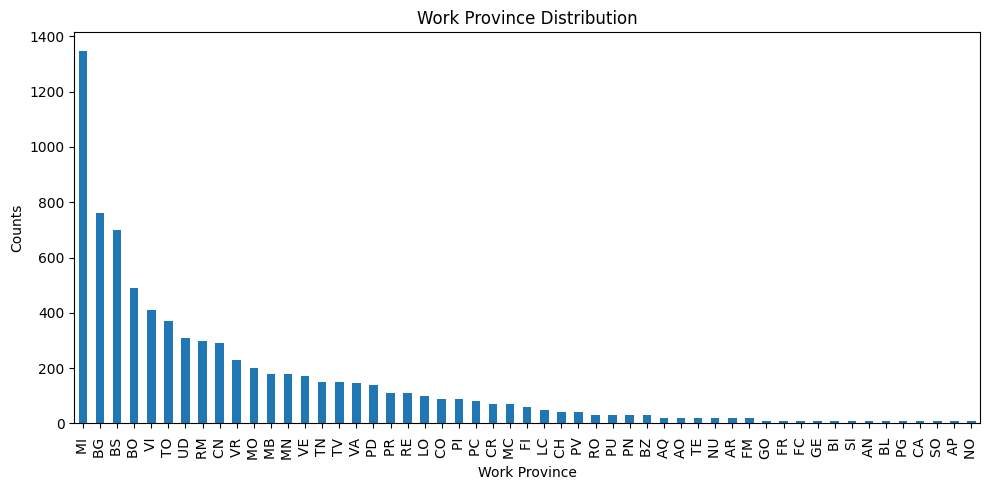

In [80]:
# Visualize the distribution
plt.figure(figsize=(10, 5))
df1['job_work_province'].value_counts().plot(kind='bar')
plt.xlabel('Work Province')
plt.ylabel('Counts')
plt.title('Work Province Distribution')
plt.tight_layout()
plt.show()

In [81]:
df1['job_work_province'] = province_encoder.fit_transform(df1[['job_work_province']])

In [82]:
#df1['job_work_province'] = df1['job_work_province'].apply(lambda p : province_to_idx[str.strip(p)])

### Considerations

Let's check the statistics of the dataset after the preprocessing

In [83]:
df1.describe(include='all')

,distance_km,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,job_contract_type,job_professional_category,job_sector,job_work_province,hired
count,7800.000000,7800.000000,7800.000000,7800.000000,7800.000000,7800.000000,7800.000000,7800.000000,7800.000000,7800.000000,7800.000000
mean,29.512179,0.572692,1.899359,39.075513,8.287051,5.246538,0.622051,137.713974,5.614615,27.011026,0.372179
std,23.041244,0.494719,1.177317,23.650088,4.390368,1.499536,0.924500,67.415677,2.342227,15.928690,0.483417
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,13.000000,0.000000,1.000000,11.000000,7.000000,6.000000,0.000000,103.000000,4.000000,9.000000,0.000000
50%,23.000000,1.000000,2.000000,38.000000,7.000000,6.000000,0.000000,126.000000,7.000000,26.000000,0.000000
75%,41.000000,1.000000,3.000000,59.000000,10.000000,6.000000,2.000000,206.000000,7.000000,44.000000,1.000000
max,100.000000,1.000000,4.000000,77.000000,17.000000,7.000000,2.000000,246.000000,9.000000,52.000000,1.000000


As we can observe, there are no more missing values, and the target lable distribution is uniform, thus there is no unbalance.

## Correlation Matrix

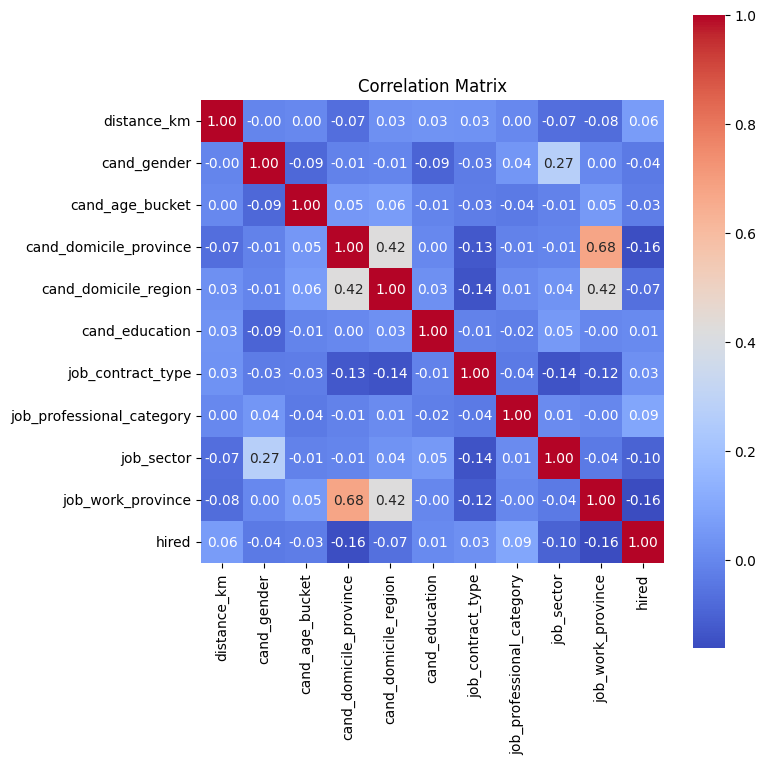

In [84]:
plt.figure(figsize=(8, 8))
sns.heatmap(df1.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

There is a small negative correlation between education and gender and a stronger positive correlation between gender and job sector, but the correlation matrix is only able to catch linear correlations. As we inspected before (and as the correlation matrix suggests) the job sector seems to act as a proxy for the candidate gender, therefore we will monitor it inside the sensible features.

In [85]:
sensitive_features.append('job_sector')

In [86]:
df1.sensitive = set(sensitive_features)

## Statistical Parity Difference
Statistical Parity Difference (SPD) measures the difference in positive outcome rates between privileged and unprivileged groups in AI decision-making. A value of 0 indicates fairness, meaning both groups receive favorable outcomes at the same rate.

In [190]:
spd = df1.statistical_parity_difference()

In [174]:
print(spd)

{(hired=0, cand_age_bucket=0): -0.03686695724366951, (hired=0, cand_age_bucket=1): -0.004796506106478748, (hired=0, cand_age_bucket=2): -0.02292620351798791, (hired=0, cand_age_bucket=3): 0.04677286649100987, (hired=0, cand_age_bucket=4): 0.009508568846001264, (hired=1, cand_age_bucket=0): 0.03686695724366956, (hired=1, cand_age_bucket=1): 0.004796506106478748, (hired=1, cand_age_bucket=2): 0.022926203517987964, (hired=1, cand_age_bucket=3): -0.04677286649100992, (hired=1, cand_age_bucket=4): -0.009508568846001264, (hired=0, cand_gender=0): -0.03590023206484516, (hired=0, cand_gender=1): 0.03590023206484516, (hired=1, cand_gender=0): 0.03590023206484516, (hired=1, cand_gender=1): -0.03590023206484516, (hired=0, job_sector=0.0): -0.2974613749928206, (hired=0, job_sector=1.0): -0.07627323024542498, (hired=0, job_sector=2.0): 0.19452719551092468, (hired=0, job_sector=3.0): -0.2823736468087932, (hired=0, job_sector=4.0): -0.004121964991530169, (hired=0, job_sector=5.0): -0.0094700764994410

In [ ]:
labels = [f"{item}" for _, item in spd[{'hired': 1}].keys()]
values = list(spd[{'hired': 1}].values())

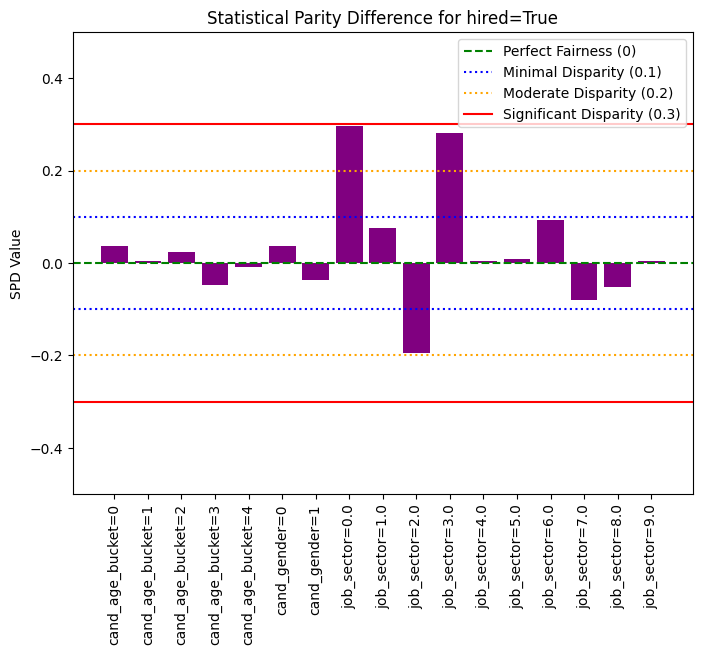

In [ ]:
plt.figure(figsize=(8, 6))

plt.axhline(y=0, color='green', linestyle='--', label="Perfect Fairness (0)")

plt.axhline(y=0.1, color='blue', linestyle=':', label="Minimal Disparity (0.1)")
plt.axhline(y=-0.1, color='blue', linestyle=':')
plt.axhline(y=0.2, color='orange', linestyle=':', label="Moderate Disparity (0.2)")
plt.axhline(y=-0.2, color='orange', linestyle=':')
plt.axhline(y=0.3, color='red', linestyle='-', label="Significant Disparity (0.3)")
plt.axhline(y=-0.3, color='red', linestyle='-')

plt.bar(labels, values, color=['purple', 'purple'])

plt.title("Statistical Parity Difference for hired=True")
plt.ylabel("SPD Value")
plt.xticks(rotation=90)
plt.ylim([-0.5, 0.5])

plt.legend()
plt.show()

As we expected, we have a significant disparity for some job sectors (which is a proxy for the gender). However, since we don't have a gold standard and we set a hiring threshold arbitrarily, the results and the disparity might drastically change for some other threshold. Anyway, we will continue assuming that the true distributions of the features are these ones.

In [185]:
# SPD values for job_sector when hired=1
spd_job_sector = {
    0.0: 0.2974613749928206,
    1.0: 0.07627323024542487,
    2.0: -0.19452719551092462,
    3.0: 0.28237364680879323,
    4.0: 0.004121964991530225,
    5.0: 0.009470076499441094,
    6.0: 0.09353165973982525,
    7.0: -0.0794229411869728,
    8.0: -0.05132542537095208,
    9.0: 0.0052410650035979445,
} # TODO automatize

# Get sector labels
sector_labels = sector_encoder.categories_[0]

# Pair each index with its SPD and label
sector_spd = [
    (int(idx), label, spd_job_sector[idx])
    for idx, label in enumerate(sector_labels)
    if idx in spd_job_sector
]

# Sort by absolute SPD descending
sector_spd_sorted = sorted(sector_spd, key=lambda x: abs(x[2]), reverse=True)

# Print the most biased sectors
for idx, label, spd in sector_spd_sorted:
    print(f"Index {idx}: {label} | SPD: {spd:.3f}") if abs(spd) > 0.08 else None

Index 0: Bar / Catering / Personale Di Sala / Cuochi / Chef | SPD: 0.297
Index 3: GDO / Retail / Commessi / Scaffalisti | SPD: 0.282
Index 2: Finanza / Contabilità | SPD: -0.195
Index 6: Manutenzione / Riparazione | SPD: 0.094


## Disparate Impact
Disparate Impact is a fairness metric that measures the ratio of favorable outcomes between unprivileged and privileged groups (e.g. historically speaking, priviliged groups can be males) It helps identify if a model or decision-making process disproportionately affects different demographic groups.

A value of 1.0 indicates perfect fairness (equal treatment), while values below 1.0 suggest the privileged group receives more favorable outcomes. Values above 1.0 indicate the unprivileged group receives more favorable outcomes.

In [181]:
di = df1.disparate_impact()

In [182]:
labels = [f"{item}" for _,item in di[{'hired': 1}].keys()]
values = list(di[{'hired': 1}].values())

In [183]:
di

(hired=0, cand_age_bucket=0) -> 1.061992845301457
(hired=0, cand_age_bucket=1) -> 1.0076791646710912
(hired=0, cand_age_bucket=2) -> 1.0375512026878744
(hired=0, cand_age_bucket=3) -> 0.9296463531728023
(hired=0, cand_age_bucket=4) -> 0.9850555288925751
(hired=1, cand_age_bucket=0) -> 0.9090385353987965
(hired=1, cand_age_bucket=1) -> 0.9872225033204731
(hired=1, cand_age_bucket=2) -> 0.9411345939123147
(hired=1, cand_age_bucket=3) -> 1.139547618157244
(hired=1, cand_age_bucket=4) -> 1.026141112470041
(hired=0, cand_gender=0) -> 1.05911831693287
(hired=0, cand_gender=1) -> 0.9441815744400754
(hired=1, cand_gender=0) -> 0.9085901654147219
(hired=1, cand_gender=1) -> 1.1006062337726872
(hired=0, job_sector=0.0) -> 1.8771296954916505
(hired=0, job_sector=1.0) -> 1.1373641113424715
(hired=0, job_sector=2.0) -> 0.7595179853660816
(hired=0, job_sector=3.0) -> 1.7667905064204297
(hired=0, job_sector=4.0) -> 1.006607730139094
(hired=0, job_sector=5.0) -> 1.015277896852614
(hired=0, job_sector=

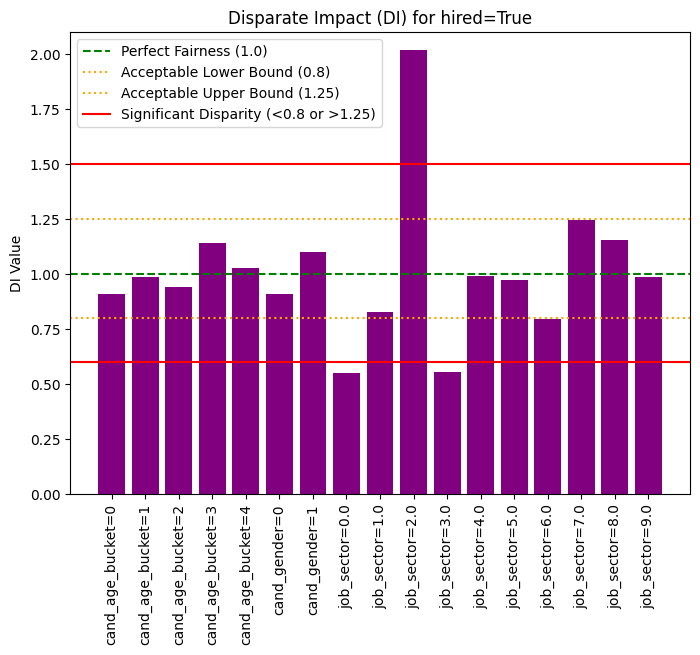

In [194]:
plt.figure(figsize=(8, 6))

# Linea di riferimento per Disparate Impact ideale
plt.axhline(y=1.0, color='green', linestyle='--', label="Perfect Fairness (1.0)")

# Soglie della regola dell'80%
plt.axhline(y=0.8, color='orange', linestyle=':', label="Acceptable Lower Bound (0.8)")
plt.axhline(y=1.25, color='orange', linestyle=':', label="Acceptable Upper Bound (1.25)")

# Linee per disparità significativa
plt.axhline(y=0.6, color='red', linestyle='-', label="Significant Disparity (<0.8 or >1.25)")
plt.axhline(y=1.5, color='red', linestyle='-')

# Barre dei modelli
plt.bar(labels, values, color='purple')

plt.title("Disparate Impact (DI) for hired=True")
plt.ylabel("DI Value")
plt.ylim([0, 2.1])
plt.xticks(range(len(labels)), rotation=90)

plt.legend()
plt.show()

As we can see, the job sectors 'Bar / Catering...' and 'GDO / Retail...' are experiencing significant **adverse impact**, as indicated by a disparate impact score < 0.6. This means that candidates from these sectors have a substantially lower likelihood of being hired, which is an unfavorable outcome for them (we refer to the avg likelihood of being hired, we do not refer to a specific reference group)

People from "Finanza / Contabilità" have instead way much likelihood to be hired.

## Classification

In [100]:
sensitive_feature = 'job_sector'
target = df1.targets.pop()

baseline_performance_metrics = []
baseline_fairness_metrics = []

preprocessing_performance_metrics = []
preprocessing_fairness_metrics = []

inprocessing_performance_metrics = []
inprocessing_fairness_metrics = []

In [101]:
def compute_performance_metrics(y_true, y_pred, y_proba):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'auc': roc_auc_score(y_true, y_proba)
    }

In [103]:
def compute_fairness_metrics(y_true, y_pred, sensitive_features):
    return {
        'dpr': demographic_parity_ratio(y_true, y_pred, sensitive_features=sensitive_features),
        'eor': equalized_odds_ratio(y_true, y_pred, sensitive_features=sensitive_features)
    }

In [104]:
def evaluate_spd(X_test, y_pred):
    X_test_copy = X_test.copy()
    X_test_copy[target] = y_pred
    dataset = fl.DataFrame(X_test_copy)
    dataset.targets = target
    dataset.sensitive = sensitive_feature

    spd = dataset.statistical_parity_difference()
    return spd

In [105]:
def metrics_bar_plot(dict1, dict2, label1, label2, metrics):
    def summarise(fold_dicts):
        mean = [np.mean([fold[m] for fold in fold_dicts]) for m in metrics]
        std  = [np.std( [fold[m] for fold in fold_dicts]) for m in metrics]
        return np.array(mean), np.array(std)

    mean1, std1 = summarise(dict1)
    mean2, std2 = summarise(dict2)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    for ax, mean, std, title in zip(axes, [mean1, mean2], [std1,  std2], [label1, label2]):
    
        ax.bar(metrics, mean, yerr=std, capsize=4)
        ax.set_title(title)
        ax.set_ylim(0, 1)              
        ax.grid(axis="y", alpha=.3)

    fig.suptitle("Performance (5-fold CV mean ± std)")
    plt.tight_layout()
    plt.show()

In [106]:
class Simple_NN(nn.Module):
    def __init__(self):
        super(Simple_NN, self).__init__()
        input_dim = df1.shape[-1]-1
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.layer3(x))
        return x

In [201]:
import xgboost as xgb

In [202]:
X = df1.drop(columns=[target])
y = df1[target]

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in kf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # We don't really need a classifier in this section, we only need to compute
    # the average performance of the baseline.
    baseline = LogisticRegression(max_iter=1000, solver='liblinear')

    baseline.fit(X_train, y_train)
    y_pred = baseline.predict(X_test)
    y_proba = baseline.predict_proba(X_test)[:, 1]

    baseline_performance_metrics.append(compute_performance_metrics(y_test, y_pred, y_proba))
    baseline_fairness_metrics.append(compute_fairness_metrics(y_test, y_pred, X_test[sensitive_feature]))

    baseline_spd = evaluate_spd(X_test, y_pred)

    # Now we do the same using a PRE-Processing technique to mitigate the dataset
    X_train_with_target = X_train.copy()
    X_train_with_target[target] = y_train.copy()
    train_dataset = fl.DataFrame(X_train_with_target)
    train_dataset.targets = target
    train_dataset.sensitive = [sensitive_feature]

    reweighing = fl.Reweighing()
    reweighed_df = reweighing.fit_transform(train_dataset)
    weights = reweighed_df['weights'].values

    X_train_reweighed = X_train.copy()

    reweighed_clf = LogisticRegression(random_state=42, max_iter=1000)
    
    reweighed_clf.fit(X_train_reweighed, y_train, sample_weight=weights)
    reweighed_pred = reweighed_clf.predict(X_test)
    reweighed_proba = reweighed_clf.predict_proba(X_test)[:, 1]

    preprocessing_performance_metrics.append(compute_performance_metrics(y_test, reweighed_pred, reweighed_proba))
    preprocessing_fairness_metrics.append(compute_fairness_metrics(y_test, reweighed_pred, X_test[sensitive_feature]))

    reweighed_spd = evaluate_spd(X_test, reweighed_pred)

    # XGBoost Reweighing
    xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_clf.fit(X_train_reweighed, y_train, sample_weight=weights)

    xgb_pred = xgb_clf.predict(X_test)
    xgb_proba = xgb_clf.predict_proba(X_test)[:, 1]

    # Store metrics for XGBoost
    preprocessing_performance_metrics.append(compute_performance_metrics(y_test, xgb_pred, xgb_proba))
    preprocessing_fairness_metrics.append(compute_fairness_metrics(y_test, xgb_pred, X_test[sensitive_feature]))

    xgb_spd = evaluate_spd(X_test, xgb_pred)

    # Same using IN-Processing technique
    regularization = 0.5
    epochs = 100
    batch_size = 128
    backbone_model = Simple_NN()
    optimizer = torch.optim.Adam(backbone_model.parameters(), lr=0.001)

    fauci_model = fl.Fauci(
        torchModel=backbone_model,
        optimizer=optimizer,
        loss=nn.BCELoss(),
        fairness_regularization="spd",
        regularization_weight=regularization
    )

    train_data = fl.DataFrame(X_train)
    train_data[target] = y_train.values
    train_data.targets = target
    train_data.sensitive = [sensitive_feature]

    fauci_model.fit(train_data, epochs=epochs, batch_size=batch_size, verbose=False)

    backbone_model.eval()
    with torch.no_grad():
        y_pred_fauci = fauci_model.predict(X_test)
        y_pred_fauci_binary = (y_pred_fauci > 0.5).float()
        y_pred_baseline = y_pred_fauci_binary.squeeze(1).detach().cpu().numpy()

        inprocessing_performance_metrics.append(compute_performance_metrics(y_test, y_pred_baseline, y_pred_fauci[:,0]))
        inprocessing_fairness_metrics.append(compute_fairness_metrics(y_test, y_pred_baseline, X_test[sensitive_feature]))

        fauci_spd = evaluate_spd(X_test, y_pred_baseline)

c:\Users\follo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:10:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\follo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:11:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\follo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\follo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost

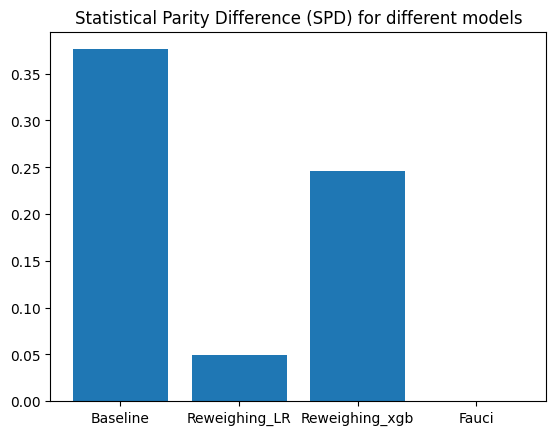

In [205]:
results = pd.DataFrame({
    'Model': ['Baseline', 'Reweighing_LR', "Reweighing_xgb", 'Fauci'],
    'SPD': [abs(list(baseline_spd.values())[0]), abs(list(reweighed_spd.values())[0]), abs(list(xgb_spd.values())[0]), abs(list(fauci_spd.values())[0])]
})

plt.title("Statistical Parity Difference (SPD) for different models")
plt.bar(results['Model'], results['SPD']);

XGBoost produces higher SPD values: this is likely due to the higher complexity of the model, which may overfits to weighted data.

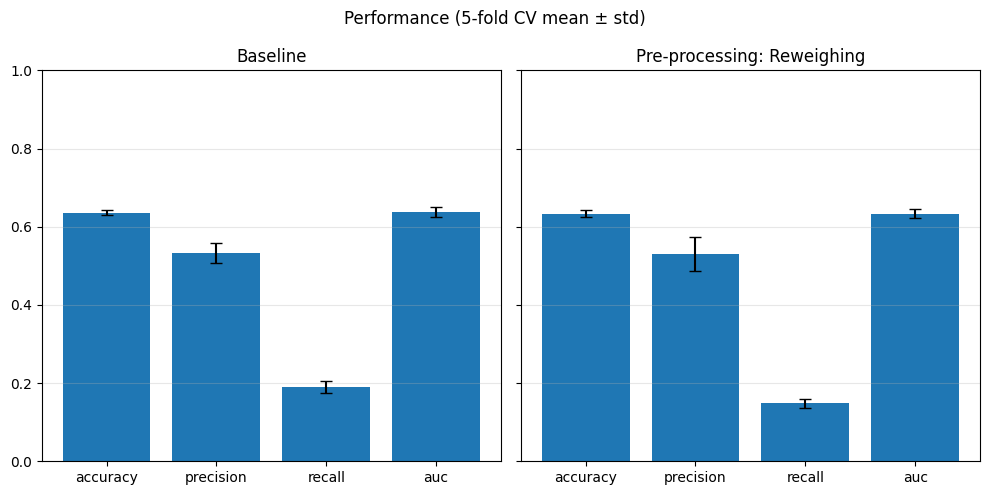

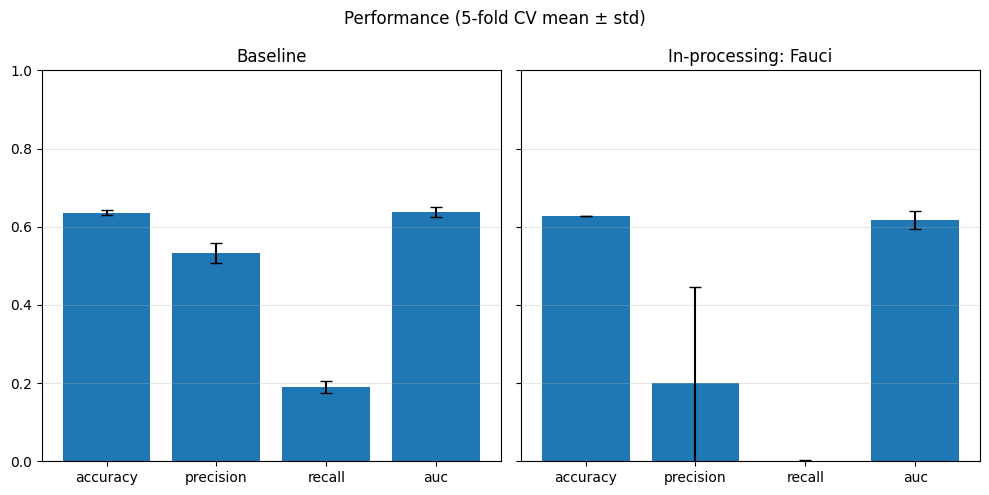

In [197]:
metrics_bar_plot(baseline_performance_metrics, 
                 preprocessing_performance_metrics, 
                 label1='Baseline', 
                 label2='Pre-processing: Reweighing',
                 metrics=['accuracy', 'precision', 'recall', 'auc'])

metrics_bar_plot(baseline_performance_metrics, 
                 inprocessing_performance_metrics, 
                 label1='Baseline', 
                 label2='In-processing: Fauci',
                 metrics=['accuracy', 'precision', 'recall', 'auc'])

The improvements from the baseline logistic regressor to fauci are probably thanks to the higher expressivity of neural networks.

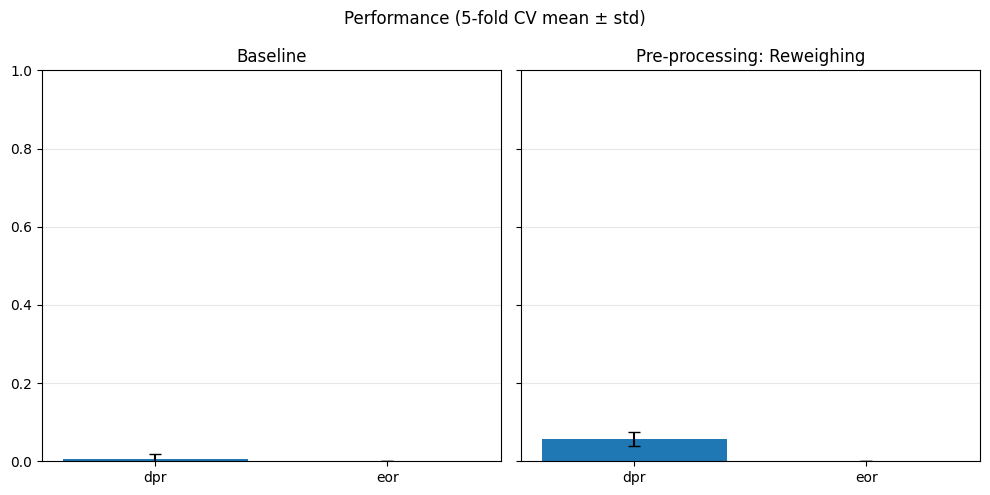

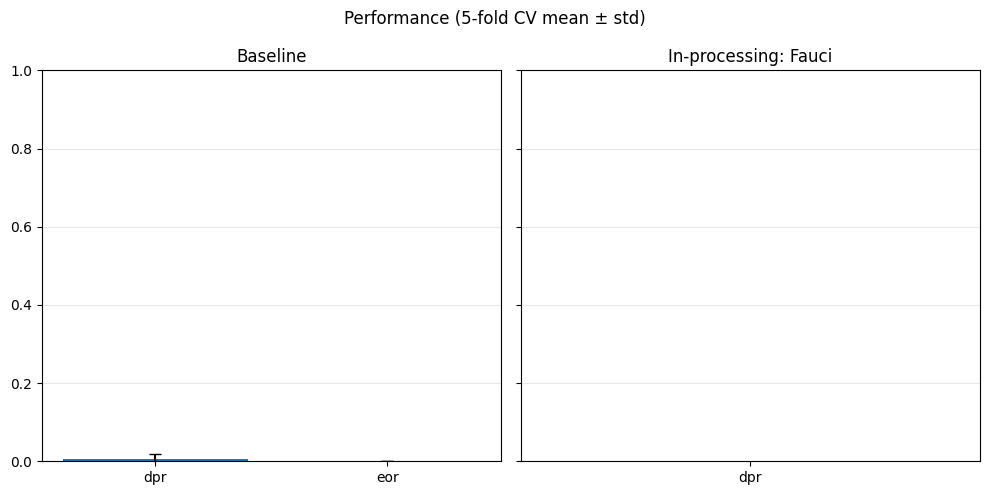

In [198]:
metrics_bar_plot(baseline_fairness_metrics, 
                 preprocessing_fairness_metrics, 
                 label1='Baseline', 
                 label2='Pre-processing: Reweighing',
                 metrics=['dpr','eor'])

metrics_bar_plot(baseline_fairness_metrics, 
                 inprocessing_fairness_metrics, 
                 label1='Baseline', 
                 label2='In-processing: Fauci',
                 metrics=['dpr','eor'])